For how to setup the environment, refer to [setup nanoGPT env](./setup_nanoGPT_env.md)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        o = Value(self.data + other.data, (self, other), "+")
        return o
    
    def __mul__(self, other):
        o = Value(self.data * other.data, (self, other), "*")
        return o

In [53]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a*b; e.label = "e"
d = e+c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"

In [54]:
# to install graphviz:
# 1. sudo apt install graphviz
# 2. pip install graphviz

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        #dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

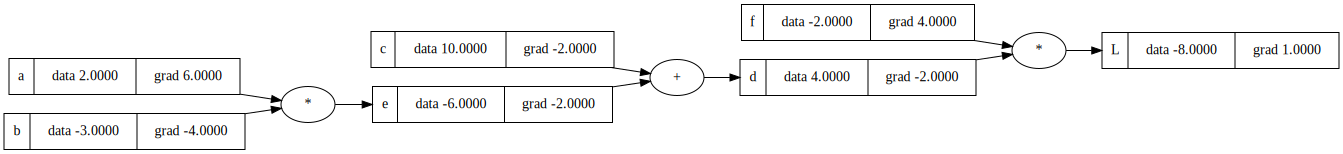

In [73]:
draw_dot(L)

In [72]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
a.grad = e.grad * b.data
b.grad = e.grad * a.data

In [75]:
def lol():
    h = 0.000001
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label = "e"
    d = e+c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    b.data += h
    c = Value(10.0, label="c")
    e = a*b; e.label = "e"; 
    d = e+c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data
    print((L2-L1)/h)


lol()

-4.000000000559112


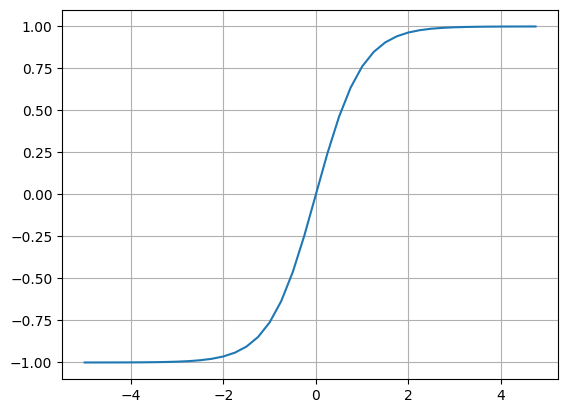

In [77]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid()

In [ ]:
class Value:
  def __init__(self, d, _children=(), _op="", label=""):
    self.data = d
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  def __repr__(self):
    return f"Value(data={self.data},label={self.label})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, _children=(self, other), _op="+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, _children=(self, other), _op="*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, _children=(self,), _op="tanh")
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for c in v._prev:
          build_topo(c)
        topo.append(v)
      
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:

# to install graphviz:
# 1. sudo apt install graphviz
# 2. pip install graphviz

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.881375, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2" 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label="o"

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
class Value:
  def __init__(self, d, _children=(), _op="", label=""):
    self.data = d
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  def __repr__(self):
    return f"Value(data={self.data},label={self.label})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children=(self, other), _op="+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __radd__(self, other):
    return self + other
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children=(self, other), _op="*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __truediv__(self, other):
    return self * (other**-1)
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only surpporting int/float powers for now"
    out = Value(self.data**other, (self,), f"x**{other}")
    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out
  
  def __neg__(self):
    return self * (-1)
  
  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, _children=(self,), _op="tanh")
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def exp(self):
    out = Value(math.exp(self.data), _children=(self,), _op="exp", label="exp")
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for c in v._prev:
          build_topo(c)
        topo.append(v)
      
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.881375, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2" 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label="o"
o.backward()

In [ ]:

draw_dot(o)

In [ ]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.881375, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2" 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"
e = (2*n).exp()
o = (e-1)/(e+1); o.label="o"
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8814]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("-----")
print("w1", w1.grad.item())
print("x1", x1.grad.item())
print("w2", w2.grad.item())
print("x2", x2.grad.item())

In [ ]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [neu(x) for neu in self.neurons]
    return outs[0] if len(outs)==1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
#draw_dot(n(x))

In [ ]:
len(n.parameters())

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

In [ ]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

In [ ]:
# 1. forward pass
ypred = [n(x) for x in xs]
print(ypred)
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print(loss)

In [ ]:
# 2. backward pass
loss.backward()

In [ ]:
# 3. update
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
for k in range(20):
  # 1. forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
  # 2. backward pass
  # zero grad
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  # 3. update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss)
